In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print("Num GPUs Available:", torch.cuda.device_count())
assert torch.cuda.is_available(), "No GPU detected: Check your Kaggle environment settings."
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Num GPUs Available: 1
Using device: cuda


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import random

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.0001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of classes: 43
Train samples: 14219
Val samples: 11955
Test samples: 11958


In [5]:
base_model = timm.create_model('regnety_032', pretrained=True, num_classes=0)

# Custom classification head
class RegNetClassifier(nn.Module):
    def __init__(self, base_model, num_classes, dropout_rate=0.3):
        super(RegNetClassifier, self).__init__()
        self.base_model = base_model
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # RegNetY-032 outputs 1512 features
        self.fc1 = nn.Linear(1512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.gelu1 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.gelu2 = nn.GELU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.gelu3 = nn.GELU()
        
        self.fc4 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout1(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.gelu1(x)
        x = self.dropout2(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu2(x)
        x = self.dropout3(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu3(x)
        
        x = self.fc4(x)
        return x

model = RegNetClassifier(base_model, num_classes, DROPOUT_RATE).to(device)

# Optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

print("Compiling model...")

model.safetensors:   0%|          | 0.00/78.1M [00:00<?, ?B/s]

Compiling model...


In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Summary:
Total parameters: 18,869,557
Trainable parameters: 18,869,557


In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [8]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7, verbose=True)

# Training loop
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
best_val_acc = 0.0
patience_counter = 0
patience = 10

print("RegNet (RegNetY-032) Starting training")
!curl -d "Train Start - RegNet" ntfy.sh/model_complete

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_RegNet_model.pth')
        print(f'Saved best model with val_acc: {val_acc:.4f}')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

print("Training completed!")
!curl -d "RegNet Train Complete" ntfy.sh/model_complete

with open('training_history_regnet.json', 'w') as f:
    json.dump(history, f)

# Load best model
model.load_state_dict(torch.load('best_RegNet_model.pth'))

RegNet (RegNetY-032) Starting training


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{"id":"JT64821LSzjd","time":1759665796,"expires":1759708996,"event":"message","topic":"model_complete","message":"Train Start - RegNet"}
Epoch 1/100
Train Loss: 2.9339, Train Acc: 0.2869
Val Loss: 2.1931, Val Acc: 0.4696
Saved best model with val_acc: 0.4696
Epoch 2/100
Train Loss: 1.6206, Train Acc: 0.6273
Val Loss: 1.1291, Val Acc: 0.7308
Saved best model with val_acc: 0.7308
Epoch 3/100
Train Loss: 0.8948, Train Acc: 0.8066
Val Loss: 0.5564, Val Acc: 0.8517
Saved best model with val_acc: 0.8517
Epoch 4/100
Train Loss: 0.5100, Train Acc: 0.8954
Val Loss: 0.3985, Val Acc: 0.8815
Saved best model with val_acc: 0.8815
Epoch 5/100
Train Loss: 0.3178, Train Acc: 0.9320
Val Loss: 0.3429, Val Acc: 0.8930
Saved best model with val_acc: 0.8930
Epoch 6/100
Train Loss: 0.2064, Train Acc: 0.9568
Val Loss: 0.2967, Val Acc: 0.9100
Saved best model with val_acc: 0.9100
Epoch 7/100
Train Loss: 0.1686, Train Acc: 0.9608
Val Loss: 0.3102, Val Acc: 0.9072
Epoch 8/100
Train Loss: 0.1386, Train Acc: 0.96

<All keys matched successfully>

Test Loss: 0.2271
Test Accuracy: 0.9545
Precision: 0.9412
Recall: 0.9269
F1 Score: 0.9329
Parameters: 18869557


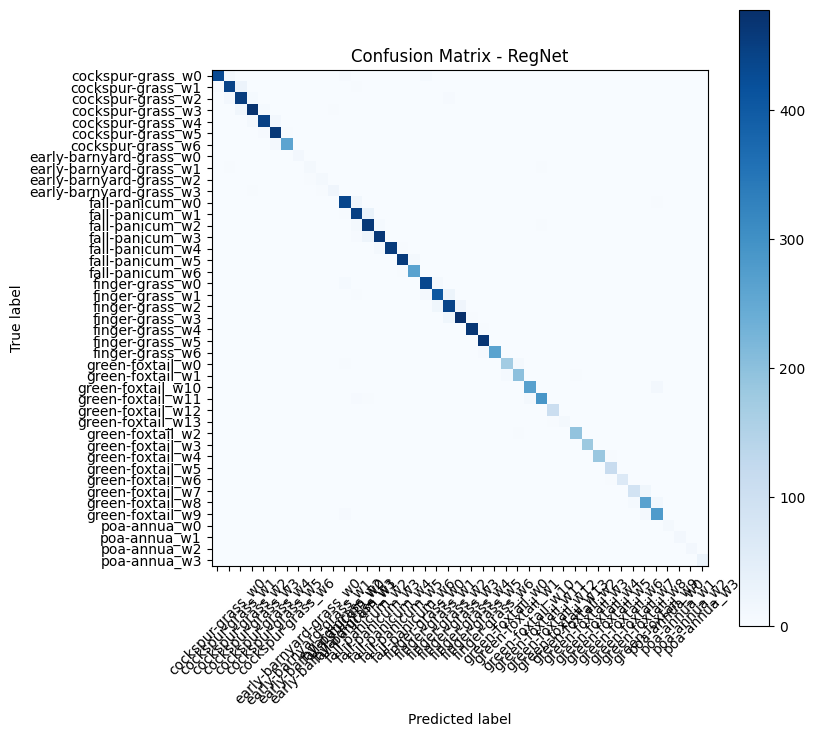

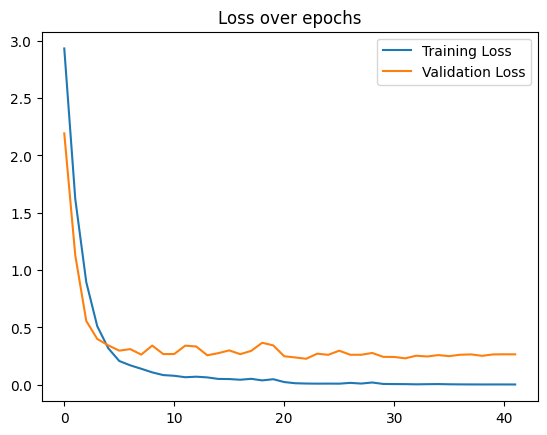

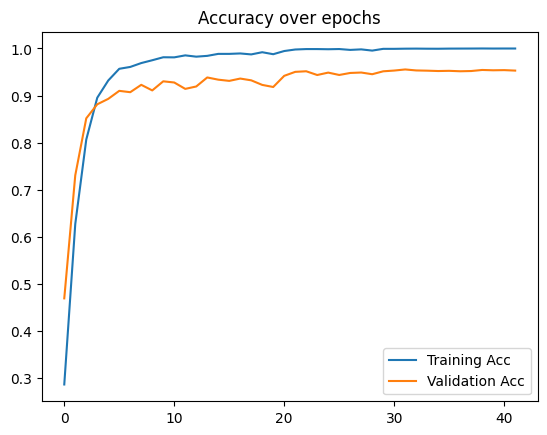

In [9]:
model.eval()
y_true = []
y_pred = []
y_pred_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

target_names = class_names
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

test_loss, test_acc = validate(model, test_loader, criterion, device)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

num_params = total_params

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RegNet")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history["accuracy"], label="Training Acc")
plt.plot(history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()

In [10]:
torch.save(model.state_dict(), 'regnet_final_model.pth')
torch.save(model, 'regnet_final_complete.pth')

| Model                |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:---------------------|---------:|------------:|-----------:|------------:|---------:|-------:|
| RegNet (RegNetY-032) | 18869557 |      0.2271 |     0.9545 |      0.9412 |   0.9269 | 0.9329 |


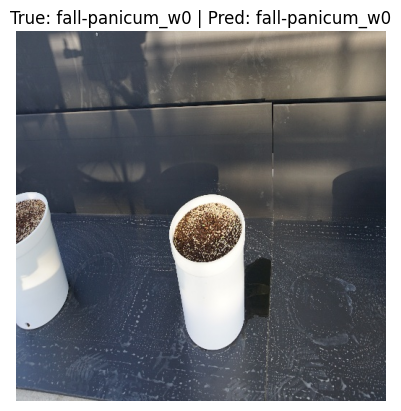

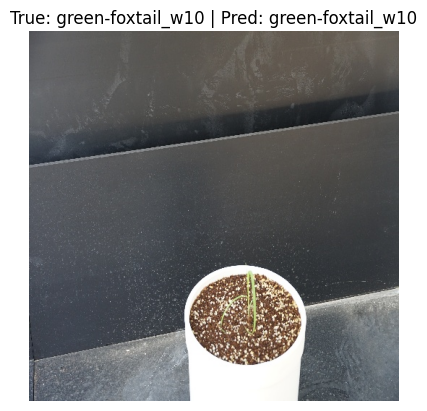

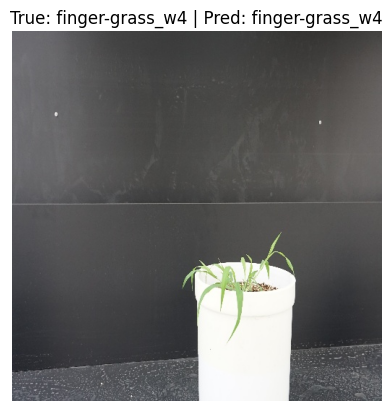

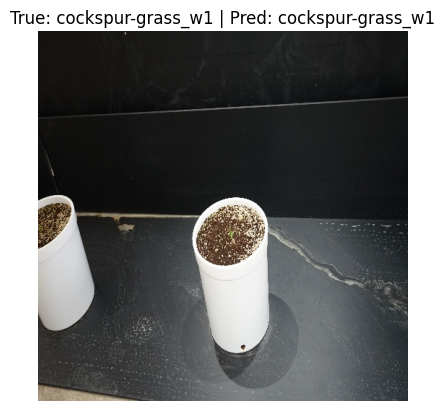

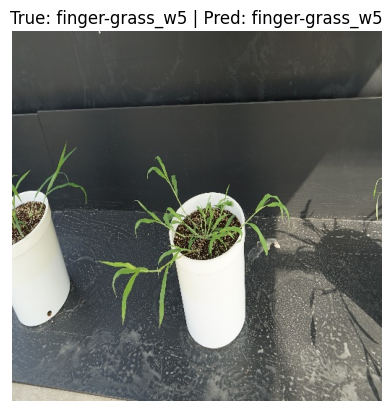

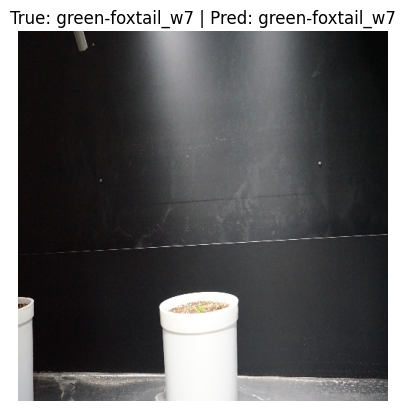

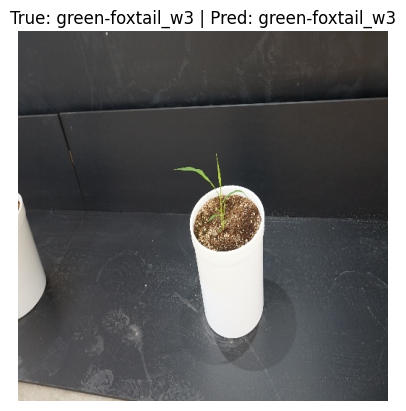

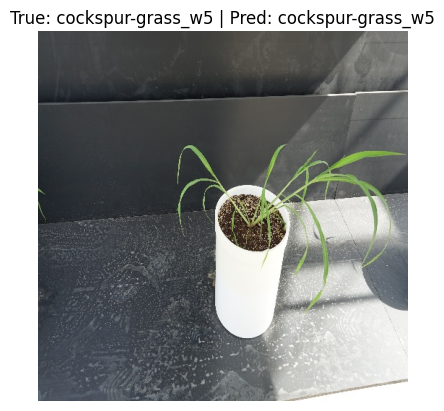

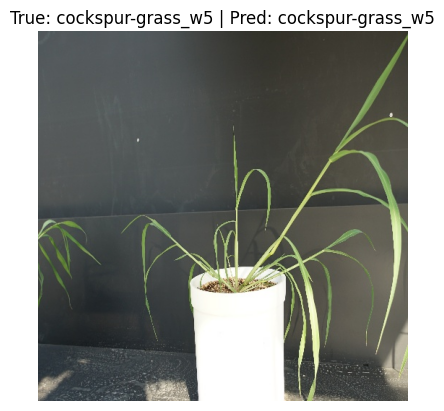

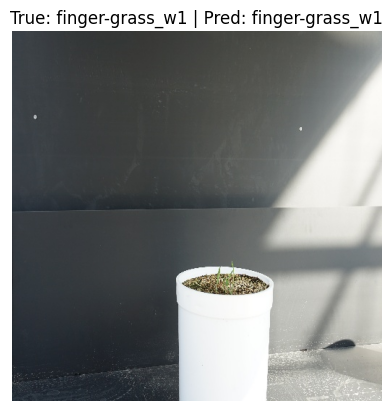

{"id":"ZGgxTUBN49uX","time":1759671724,"expires":1759714924,"event":"message","topic":"model_complete","message":"RegNet Finished"}


In [11]:
results = {
    "Model": ["RegNet (RegNetY-032)"],
    "Params": [num_params],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))

# Sample predictions
sample_idx = random.sample(range(len(test_dataset)), 10)
for idx in sample_idx:
    img_path = test_dataset.imgs[idx][0]
    img = plt.imread(img_path)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "RegNet Finished" ntfy.sh/model_complete